# 5 Automated Machine Learning : Remote Execution avec Azure Batch AI

In this example we use the scikit-learn's [digit dataset](http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) to showcase how you can use AutoML for a simple classification problem.

Make sure you have executed the [configuration](../configuration.ipynb) before running this notebook.

In this notebook you would see
1. Create an `Experiment` in an existing `Workspace`.
2. Attach an existing Batch AI compute to a workspace.
3. Configure AutoML using `AutoMLConfig`.
4. Train the model using Batch AI.
5. Explore the results.
6. Test the best fitted model.

In addition this notebook showcases the following features
- **Parallel** executions for iterations
- **Asynchronous** tracking of progress
- **Cancellation** of individual iterations or the entire run
- Retrieving models for any iteration or logged metric
- Specifying AutoML settings as `**kwargs`


In [1]:
import sys
sys.version

'3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) \n[GCC 7.2.0]'

## 6.1 Création experiment

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [2]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

In [3]:
ws = Workspace.from_config()

# Choose a name for the run history container in the workspace.
experiment_name = 'automl-remote-batchai'
project_folder = './sample_projects/automl-remote-batchai'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Found the config file in: /home/nbuser/library/aml_config/config.json


,
Experiment Name,automl-remote-batchai
Location,westeurope
Project Directory,./sample_projects/automl-remote-batchai
Resource Group,resgrpAMLS
SDK version,1.0.2
Subscription ID,70b8f39e-8863-49f7-b6ba-34a80799550c
Workspace Name,AMLSworkspace


## Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [4]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

## 6.2 Creation cluster Azure Batch AI
The cluster is created as Machine Learning Compute and will appear under your workspace.

**Note:** The creation of the Batch AI cluster can take over 10 minutes, please be patient.

As with other Azure services, there are limits on certain resources (e.g. Batch AI cluster size) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
batchai_cluster_name = "automlcl"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if batchai_cluster_name in cts and cts[batchai_cluster_name].type == 'BatchAI':
    found = True
    print('Found existing compute target.')
    compute_target = cts[batchai_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, batchai_cluster_name, provisioning_config)
    
    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min_node_count is provided, it will use the scale settings for the cluster.
    compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
     # For a more detailed view of current Batch AI cluster status, use the 'status' property.

Creating a new compute target...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [6]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to the Batch AI cluster
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]'], conda_packages=['numpy'])
conda_run_config.environment.python.conda_dependencies = cd

## Create Get Data File
For remote executions you should author a `get_data.py` file containing a `get_data()` function. This file should be in the root directory of the project. You can encapsulate code to read data either from a blob storage or local disk in this file.
In this example, the `get_data()` function returns data using scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

In [7]:
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

In [8]:
%%writefile $project_folder/get_data.py

from sklearn import datasets
from scipy import sparse
import numpy as np

def get_data():
    
    digits = datasets.load_digits()
    X_train = digits.data
    y_train = digits.target

    return { "X" : X_train, "y" : y_train }

Overwriting ./sample_projects/automl-remote-batchai/get_data.py


## 6.3 AutoML <a class="anchor" id="Instatiate-AutoML-Remote-DSVM"></a>

You can specify `automl_settings` as `**kwargs` as well. Also note that you can use a `get_data()` function for local excutions too.

**Note:** When using Batch AI, you can't pass Numpy arrays directly to the fit method.

|Property|Description|
|-|-|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**max_concurrent_iterations**|Maximum number of iterations that would be executed in parallel. This should be less than the number of cores on the DSVM.|

In [9]:
automl_settings = {
    "iteration_timeout_minutes": 2,
    "iterations": 10,
    "n_cross_validations": 3,
    "primary_metric": 'AUC_weighted',
    "preprocess": False,
    "max_concurrent_iterations": 5,
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             path = project_folder,
                             run_configuration=conda_run_config,
                             data_script = project_folder + "/get_data.py",
                             **automl_settings
                            )


## Aprentissage du modèle

Call the `submit` method on the experiment object and pass the run configuration. For remote runs the execution is asynchronous, so you will see the iterations get populated as they complete. You can interact with the widgets and models even when the experiment is running to retrieve the best model up to that point. Once you are satisfied with the model, you can cancel a particular iteration or the whole run.
In this example, we specify `show_output = False` to suppress console output while the run is in progress.

In [10]:
remote_run = experiment.submit(automl_config, show_output = False)

## 6.4 Exploration des résultats

### 6.5 Chargement
In case you need to load a previously executed run, enable the cell below and replace the `run_id` value.

### 6.6 Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

You can click on a pipeline to see run properties and output logs.  Logs are also available on the DSVM under `/tmp/azureml_run/{iterationid}/azureml-logs`

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [11]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-remote-batchai,AutoML_e7ba8efd-2f6d-42ca-9116-d5e4119dfcc4,automl,Preparing,Link to Azure Portal,Link to Documentation


In [12]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

In [13]:
# Wait until the run finishes.
remote_run.wait_for_completion(show_output = True)


*******************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper KNN                      0:00:41       0.9979    0.9979
         1   StandardScalerWrapper KNN                      0:00:45       0.9984    0.9984
         2   RobustScaler LogisticRegression                0:00:46       0.9967    0.9984
         3   RobustScaler LightGBM                          0:00:50       0.9981    0.9984
         4   StandardScalerWrapper KNN                      0:00:55       0.9985    0.9985
         5 

{'runId': 'AutoML_e7ba8efd-2f6d-42ca-9116-d5e4119dfcc4',
 'target': 'automlcl',
 'status': 'Completed',
 'startTimeUtc': '2018-12-10T11:19:11.704449Z',
 'endTimeUtc': '2018-12-10T11:21:51.501311Z',
 'properties': {'num_iterations': '10',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'max_time_seconds': '120',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'automlcl',
  'RawAMLSettingsString': "{'name': 'automl-remote-batchai', 'path': './sample_projects/automl-remote-batchai', 'subscription_id': '70b8f39e-8863-49f7-b6ba-34a80799550c', 'resource_group': 'resgrpAMLS', 'workspace_name': 'AMLSworkspace', 'iterations': 10, 'primary_metric': 'AUC_weighted', 'data_script': './sample_projects/automl-remote-batchai/get_data.py', 'compute_target': 'automlcl', 'task_type': 'classification', 'validation_size': 0.0, 'n_cross_validations': 3, 'y_min': None, 'y_max': None, 'num_classes': None, 'p


### 6.6 Visualisation de tous les runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [14]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.997908,0.998475,0.996725,0.998126,0.998489,0.996028,0.993049,0.994442,0.998472,0.999447
AUC_micro,0.998099,0.998478,0.996694,0.998140,0.998547,0.996368,0.993683,0.995686,0.998545,0.999499
AUC_weighted,0.997880,0.998443,0.996721,0.998139,0.998468,0.995965,0.993102,0.994363,0.998451,0.999433
AUC_weighted_max,0.997880,0.998443,0.996721,0.998139,0.998468,0.997880,0.998443,0.998443,0.998451,0.999433
accuracy,0.967168,0.951029,0.943795,0.947134,0.964385,0.931553,0.914302,0.944352,0.959933,0.974958
average_precision_score_macro,0.990185,0.988821,0.979083,0.987302,0.991522,0.977224,0.960434,0.969403,0.989949,0.996349
average_precision_score_micro,0.991152,0.988357,0.979349,0.987954,0.991949,0.979429,0.965591,0.976332,0.990999,0.996487
average_precision_score_weighted,0.990244,0.988793,0.979499,0.987675,0.991506,0.977523,0.961436,0.969623,0.989987,0.996317
balanced_accuracy,0.967578,0.951354,0.944030,0.947056,0.964655,0.932184,0.915288,0.944544,0.960217,0.975028
f1_score_macro,0.967275,0.950837,0.943571,0.946159,0.964502,0.930816,0.913502,0.944165,0.959448,0.974815


## 7. Suppression de runs

You can cancel ongoing remote runs using the `cancel` and `cancel_iteration` functions.

In [15]:
# Cancel the ongoing experiment and stop scheduling new iterations.
# remote_run.cancel()

# Cancel iteration 1 and move onto iteration 2.
# remote_run.cancel_iteration(1)

## 8. Récupération du meilleur modèle 
Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [16]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-remote-batchai,
Id: AutoML_e7ba8efd-2f6d-42ca-9116-d5e4119dfcc4_9,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('KNN', Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7ffb2b99a710>), ('KNeighborsCl... warm_start=False))]))],
               flatten_transform=None, weights=[0.3, 0.1, 0.3, 0.2, 0.1]))])


### Choix autre métrique
Show the run and the model which has the smallest `log_loss` value:

In [17]:
lookup_metric = "log_loss"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-remote-batchai,
Id: AutoML_e7ba8efd-2f6d-42ca-9116-d5e4119dfcc4_9,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('KNN', Pipeline(memory=None,
     steps=[('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7ffb2b390b00>), ('KNeighborsCl... warm_start=False))]))],
               flatten_transform=None, weights=[0.3, 0.1, 0.3, 0.2, 0.1]))])


#### Choix itération
Show the run and the model from the third iteration:

In [18]:
iteration = 3
third_run, third_model = remote_run.get_output(iteration=iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-remote-batchai,
Id: AutoML_e7ba8efd-2f6d-42ca-9116-d5e4119dfcc4_3,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
     steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[10, 90], with_centering=True,
       with_scaling=False)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7ffb2b3e1cc0>)])


## 9. Test du modèle <a class="anchor" id="Testing-the-Fitted-Model-Remote-DSVM"></a>

#### Chargement des données

In [19]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

#### Test

9


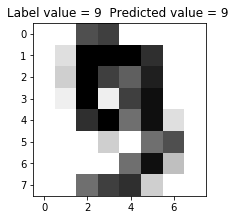

5


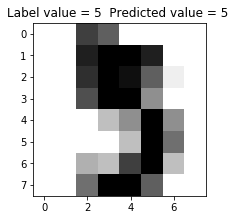

In [21]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize=(3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()